# Chapter 8 - Tree-based Methods

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pydot
from IPython.display import Image

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [2]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

### § 8.1.1 Regression Trees

In [3]:
df = pd.read_csv('Data/Hitters.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 41.1+ KB


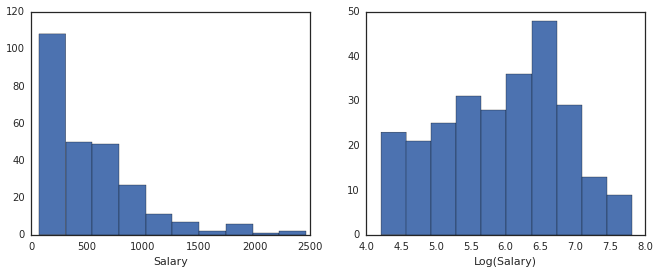

In [4]:
X = df[['Years', 'Hits']].as_matrix()
y = np.log(df.Salary.as_matrix())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(df.Salary.as_matrix())
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)')

In [5]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best')

### Figure 8.1

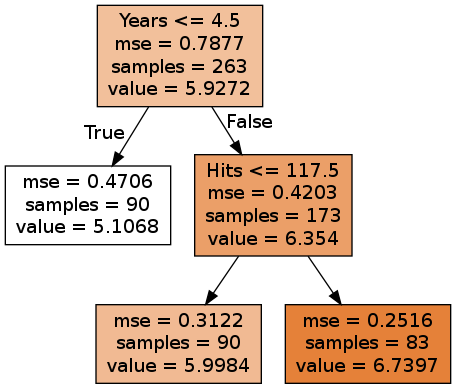

In [6]:
graph = print_tree(regr, features=['Years', 'Hits'])
Image(graph.create_png())

###  Figure 8.2

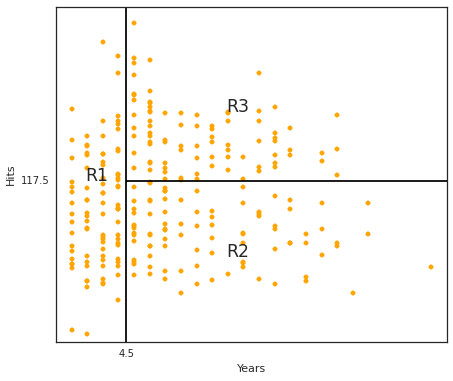

In [7]:
df.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([4.5])
plt.yticks([117.5])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large')

### Pruning
This is currently not supported in scikit-learn. See first point under 'disadvantages of decision trees in the <A href='http://scikit-learn.github.io/dev/modules/tree.html#'>documentation</A>. Implementation has been <A href='https://github.com/scikit-learn/scikit-learn/pull/941'>discussed</A> but Random Forests have better predictive qualities than a single pruned tree anyway if I understand correctly.
    

### § 8.1.2 Classification Trees

In [4]:
df2 = pd.read_csv('Data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
Age          297 non-null int64
Sex          297 non-null int64
ChestPain    297 non-null object
RestBP       297 non-null int64
Chol         297 non-null int64
Fbs          297 non-null int64
RestECG      297 non-null int64
MaxHR        297 non-null int64
ExAng        297 non-null int64
Oldpeak      297 non-null float64
Slope        297 non-null int64
Ca           297 non-null float64
Thal         297 non-null object
AHD          297 non-null object
dtypes: float64(2), int64(9), object(3)
memory usage: 31.3+ KB


In [5]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]

In [6]:
X2 = df2.drop('AHD', axis=1)
y2 = pd.factorize(df2.AHD)[0]

In [11]:
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)
clf.fit(X2,y2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=6, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [12]:
clf.score(X2,y2)

0.81144781144781142

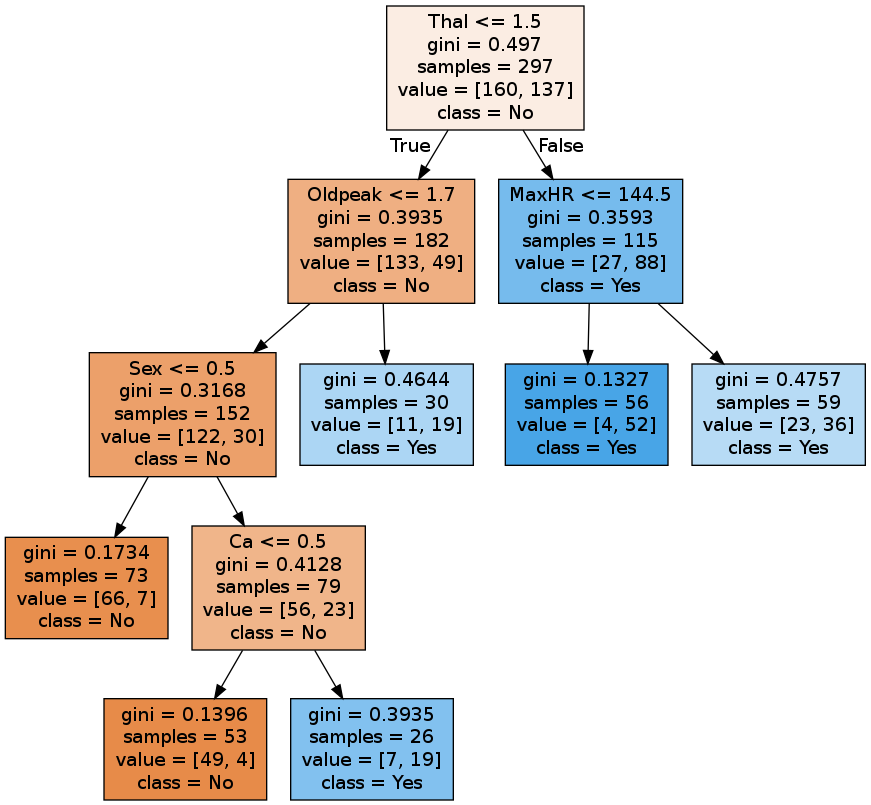

In [13]:
graph2 = print_tree(clf, features=X2.columns, class_names=['No', 'Yes'])
Image(graph2.create_png())

### § 8.2.2 Random Forests

In [32]:
clf2 = RandomForestClassifier(n_estimators=50, max_depth=3)
clf2.fit(X2,y2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
clf2.score(X2,y2)

0.87878787878787878

In [34]:
clf2.feature_importances_ / clf2.feature_importances_.max()*100

array([  19.96179307,   16.69270952,   78.51999214,   20.09383221,
         13.94815203,    0.89988823,    3.84994451,   67.23104605,
         34.24144524,   64.6636279 ,   39.59569848,   90.29741898,  100.        ])

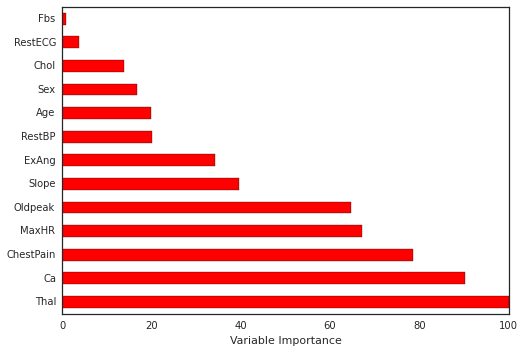

In [35]:
Importance = pd.DataFrame({'Importance':clf2.feature_importances_ / clf2.feature_importances_.max()*100}, index=X2.columns)
Importance.sort('Importance', axis=0, ascending=False).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## Lab

### § 8.3.1 Fitting Classification Trees

In [36]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
df3 = pd.read_csv('Data/Carseats.csv').drop('Unnamed: 0', axis=1)
df3.head()

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  

In [19]:
df3['High'] = df3.Sales.map(lambda x: 1 if x > 8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]
df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 12 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
ShelveLoc      400 non-null int32
Age            400 non-null int64
Education      400 non-null int64
Urban          400 non-null int64
US             400 non-null int64
High           400 non-null int64
dtypes: float64(1), int32(1), int64(10)
memory usage: 39.1 KB


In [20]:
df3.head()

   Sales  CompPrice  Income  Advertising  Population  Price  ShelveLoc  Age  \
0   9.50        138      73           11         276    120          0   42   
1  11.22        111      48           16         260     83          1   65   
2  10.06        113      35           10         269     80          2   59   
3   7.40        117     100            4         466     97          2   55   
4   4.15        141      64            3         340    128          0   38   

   Education  Urban  US  High  
0         17      1   1     1  
1         10      1   1     1  
2         12      1   1     1  
3         14      1   1     0  
4         13      1   0     0  

In [21]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [22]:
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

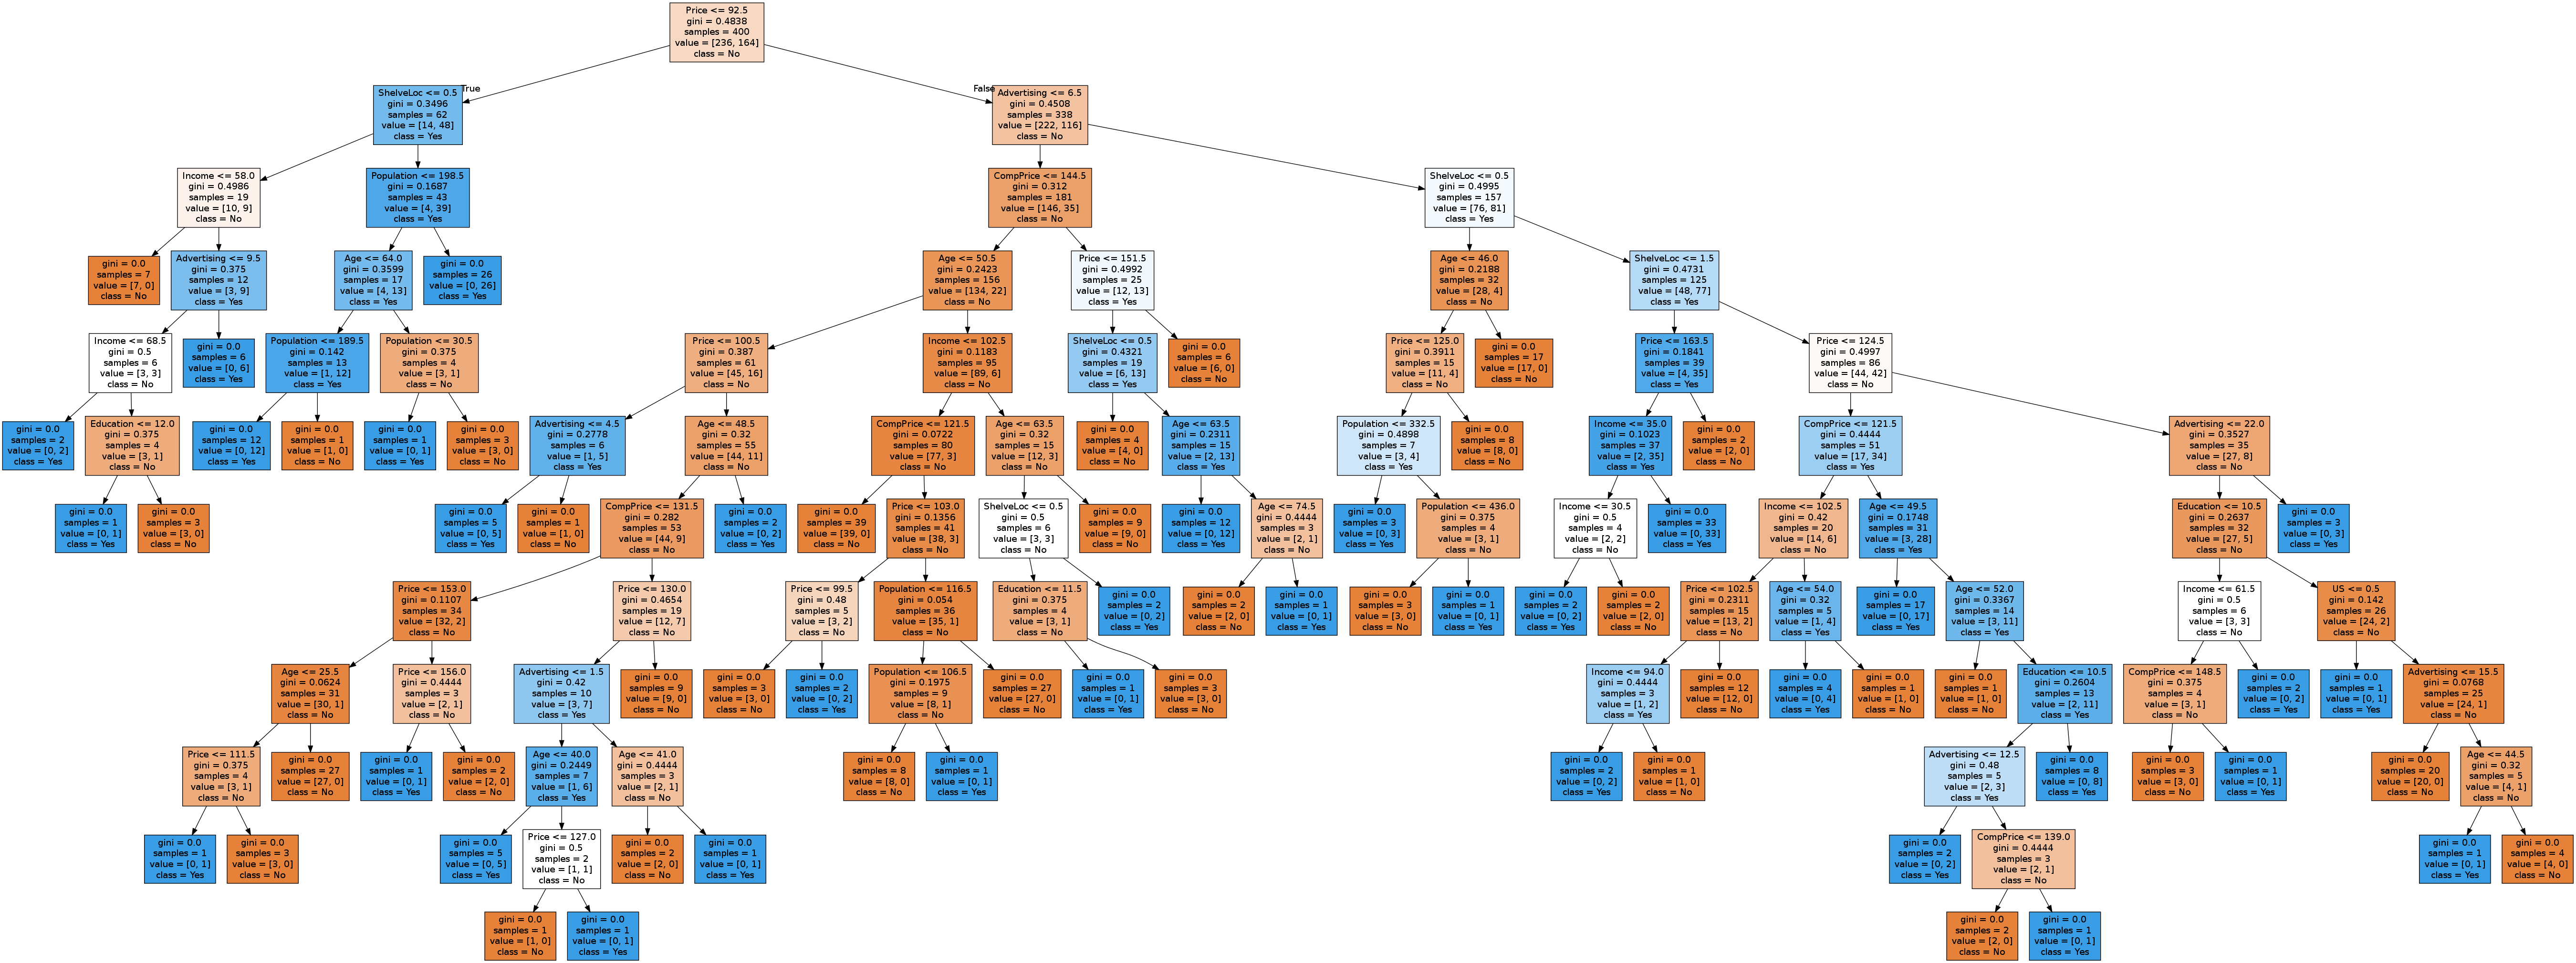

In [23]:
graph3 = print_tree(clf, features=X.columns, class_names=['No', 'Yes'])
Image(graph3.create_png())

In [24]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [25]:
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True       No  Yes
Predicted         
No         93   33
Yes        23   51

In [26]:
# Precision of the model using test data is 72%
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.74      0.80      0.77       116
          1       0.69      0.61      0.65        84

avg / total       0.72      0.72      0.72       200



Pruning not implemented in scikit-learn.

### § 8.3.2 Fitting Regression Trees

In [37]:
boston_df = pd.read_csv('Data/Boston.csv')
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 0 to 505
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 59.3 KB


In [39]:
X = boston_df.drop('medv', axis=1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [40]:
# Pruning not supported. Choosing max depth 3)
regr2 = DecisionTreeRegressor(max_depth=3)
regr2.fit(X_train.as_matrix(), y_train)
pred = regr2.predict(X_test)

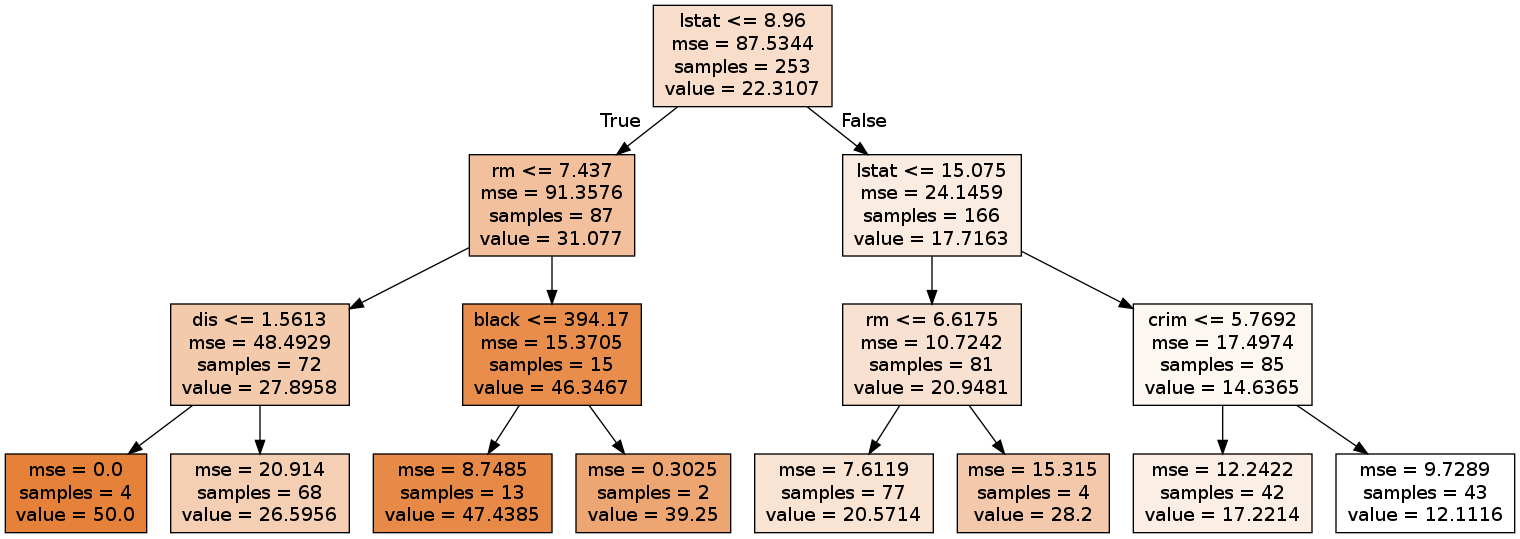

In [41]:
graph = print_tree(regr2, features=X.columns)
Image(graph.create_png())

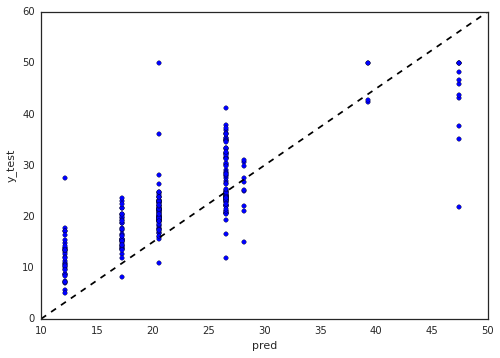

In [42]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [43]:
mean_squared_error(y_test, pred)

27.41973445905036

### § 8.3.3 Bagging and Random Forests

In [44]:
regr3 = RandomForestRegressor()
bagging = BaggingRegressor(regr3)

regr3.fit(X_train, y_train)
pred = regr3.predict(X_test)

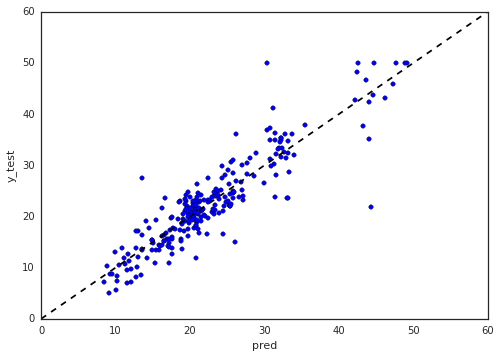

In [45]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [46]:
mean_squared_error(y_test, pred)

14.4165442687747

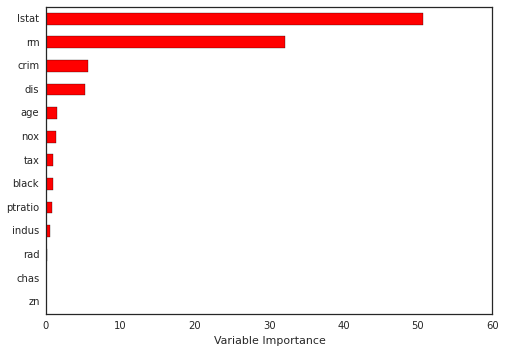

In [66]:
Importance = pd.DataFrame({'Importance':regr3.feature_importances_*100}, index=X.columns)
Importance.sort('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### § 8.3.4 Boosting

In [67]:
# Default shrinkage with gmb() in R is 0.001.
regr = GradientBoostingRegressor(learning_rate=0.001, max_depth=4, min_samples_split=1, n_estimators=2000)
regr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.001,
             loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

chas        0.107502
zn          0.171338
rad         0.258408
age         0.718988
indus       0.782876
nox         1.076446
black       1.733403
tax         2.297302
crim        3.568314
ptratio     3.693588
dis        10.242853
rm         34.729893
lstat      40.619088
dtype: float64


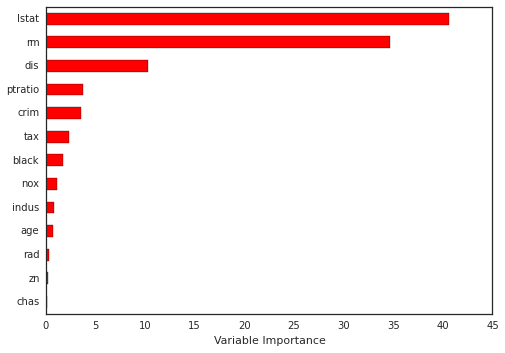

In [72]:
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [90]:
test_score = np.zeros(regr.n_estimators, dtype=np.float64)
for i, pred in enumerate(regr.staged_predict(X_test)):
                         test_score[i] = regr.loss_(y_test, pred)

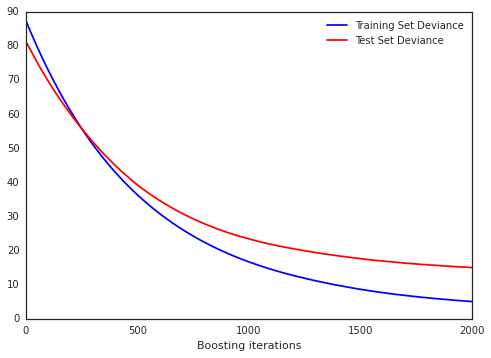

In [97]:
plt.plot(np.arange(regr.n_estimators)+1, regr.train_score_, 'b-',  label='Training Set Deviance')
plt.plot(np.arange(regr.n_estimators)+1, test_score, '-r', label='Test Set Deviance')
plt.gca().legend()
plt.xlabel('Boosting iterations')

In [96]:
mean_squared_error(y_test, regr.predict(X_test))

15.041273079876992